In [1]:
import xarray as xr
import grib2io
import pandas as pd
import datetime
from scipy.stats import gamma
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import multiprocessing
import scipy
from numba import jit

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})

from nimbl.metadata import get_metadata
conus_grid_def = get_metadata('grib2_section3', model='blend',region='co' )
conus_grid = grib2io.Grib2GridDef(conus_grid_def[4], conus_grid_def[5:])

/scratch2/STI/mdl-sti/Sidney.Lower/miniforge3/lib/python3.10/site-packages/nimbl/metadata/metadata.py:117: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadata_df = pd.concat(collect, axis="index")


In [190]:
hrrr_sample = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/hrrr_conus_grid.nc',)
hrrr_lat_idx = hrrr_sample.latitude_idx.data
hrrr_lon_idx = hrrr_sample.longitude_idx.data

gefs_sample = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/thinned_conus_grid.nc',)
gefs_lat_idx = gefs_sample.latitude_idx.data
gefs_lon_idx = gefs_sample.longitude_idx.data

consts = xr.open_dataset('/scratch1/NCEPDEV/mdl/Eric.Engle/gitrepos/blend/fix/precip/blend.precip_const.co.2p5.nc')
lat_arr = consts.latitude.data
lon_arr =  consts.longitude.data

In [3]:
import re
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]

files = sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/hrrr/bias_no_sl_*_CONUS.nc"), key=natsort)
hrrr_nosl_ds = xr.open_mfdataset(files, engine='netcdf4', combine='nested', concat_dim='day')

In [4]:
files = sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/hrrr/bias_nsls50_*_CONUS.nc"), key=natsort)
hrrr_ds = xr.open_mfdataset(files, engine='netcdf4', combine='nested', concat_dim='day')

In [76]:
i=5
files = sorted(glob(f"/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/test_number_sls/hrrr/bias_nsls{i}_*_CONUS.nc"), key=natsort)
hrrr_ds5 = xr.open_mfdataset(files, engine='netcdf4', combine='nested', concat_dim='day')

In [8]:
hrrr_nosl = hrrr_nosl_ds.groupby("day.month")
hrrr_sl = hrrr_ds.groupby("day.month")

In [7]:
hrrr_sl5 = hrrr_ds5.groupby("day.month")

NameError: name 'hrrr_ds5' is not defined

In [9]:
hrrr_sl_bias, hrrr_nosl_bias, hrrr_raw_bias = np.zeros(12), np.zeros(12), np.zeros(12)
for i in tqdm(range(1,13)):
    hrrr_sl_qmd = hrrr_sl[i].hrrr_qmd.data.compute()
    urma_analysis = hrrr_sl[i].urma_analysis.data.compute()
    hrrr_nosl_qmd = hrrr_nosl[i].hrrr_qmd.data.compute()
    hrrr_raw = hrrr_sl[i].hrrr_raw.data.compute()

    hrrr_sl_bias[i-1] = np.nanmean(np.nanmean(np.nan_to_num(hrrr_sl_qmd - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))
    hrrr_nosl_bias[i-1] = np.nanmean(np.nanmean(np.nan_to_num(hrrr_nosl_qmd - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))
    hrrr_raw_bias[i-1] = np.nanmean(np.nanmean(np.nan_to_num(hrrr_raw - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))

  0%|          | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt



Text(0.5, 1.0, 'HRRR')

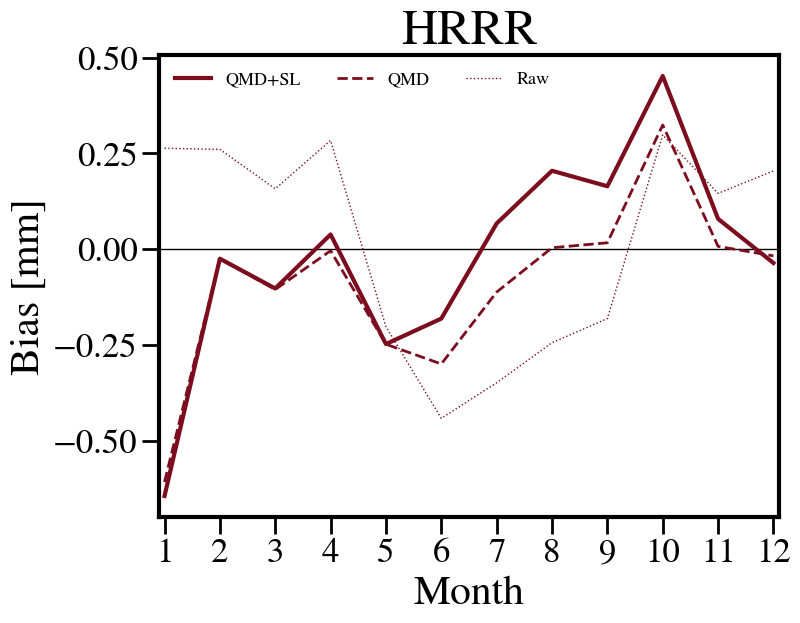

In [34]:
coolors = ['#7B0D1E']

plt.plot(np.arange(12), hrrr_sl_bias, color=coolors[0], lw=3, label='QMD+SL')
plt.plot(np.arange(12), hrrr_nosl_bias, color=coolors[0], ls='--', lw=2, label='QMD')
plt.plot(np.arange(12), hrrr_raw_bias, color=coolors[0], ls=':', lw=1, label='Raw')

plt.plot([-5,15], [0,0], color='black', lw=1, zorder=0)

plt.ylabel("Bias [mm]")
plt.xlabel('Month')

plt.xticks(np.arange(12), labels=[f"{i}" for i in range(1, 13)])
plt.xlim([-0.1,11.1])
#plt.ylim([-22, 20])
plt.legend(frameon=False, ncol=3, fontsize=13, loc='upper left')
plt.title("HRRR")

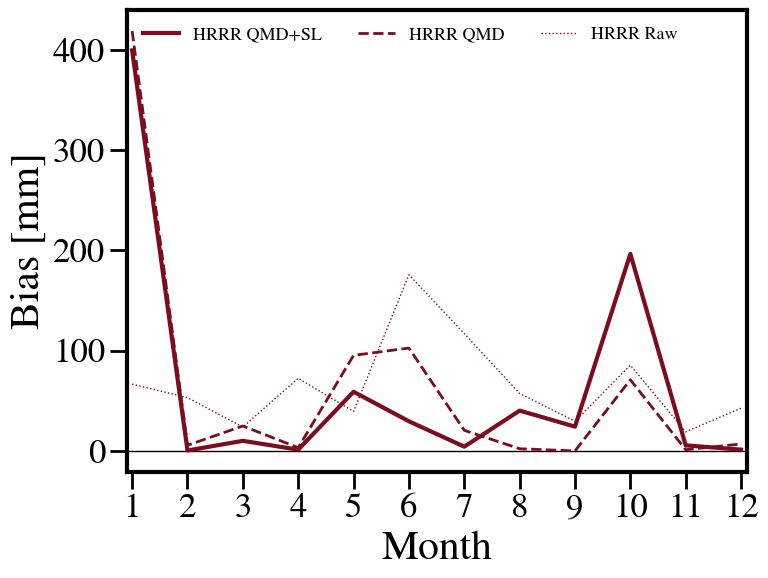

In [76]:
coolors = ['#7B0D1E']

plt.plot(np.arange(12), hrrr_sl_bias**2, color=coolors[0], lw=3, label='HRRR QMD+SL')
plt.plot(np.arange(12), hrrr_nosl_bias**2, color=coolors[0], ls='--', lw=2, label='HRRR QMD')
plt.plot(np.arange(12), hrrr_raw_bias**2, color=coolors[0], ls=':', lw=1, label='HRRR Raw')

plt.plot([-5,15], [0,0], color='black', lw=1, zorder=0)

plt.ylabel("Bias [mm]")
plt.xlabel('Month')

plt.xticks(np.arange(12), labels=[f"{i}" for i in range(1, 13)])
plt.xlim([-0.1,11.1])
#plt.ylim([-22, 20])
plt.legend(frameon=False, ncol=3, fontsize=13, loc='upper left')

In [81]:
hrrr_sl_bias, hrrr_nosl_bias, hrrr_sl5_bias = np.zeros(12), np.zeros(12), np.zeros(12)
for i in tqdm(range(1,13)):
    hrrr_sl_qmd = hrrr_sl[i].hrrr_qmd.data.compute()
    urma_analysis = hrrr_sl[i].urma_analysis.data.compute()
    hrrr_nosl_qmd = hrrr_nosl[i].hrrr_qmd.data.compute()
    #hrrr_sl5_qmd = hrrr_sl5[i].hrrr_qmd.data.compute()

    hrrr_sl_bias[i-1] = np.nanmean(np.nanmean(np.nan_to_num(hrrr_sl_qmd - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))
    hrrr_nosl_bias[i-1] = np.nanmean(np.nanmean(np.nan_to_num(hrrr_nosl_qmd - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))
    #hrrr_sl5_bias[i-1] = np.nanmean(np.nanmean(np.nan_to_num(hrrr_sl5_qmd - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))

  0%|          | 0/12 [00:00<?, ?it/s]

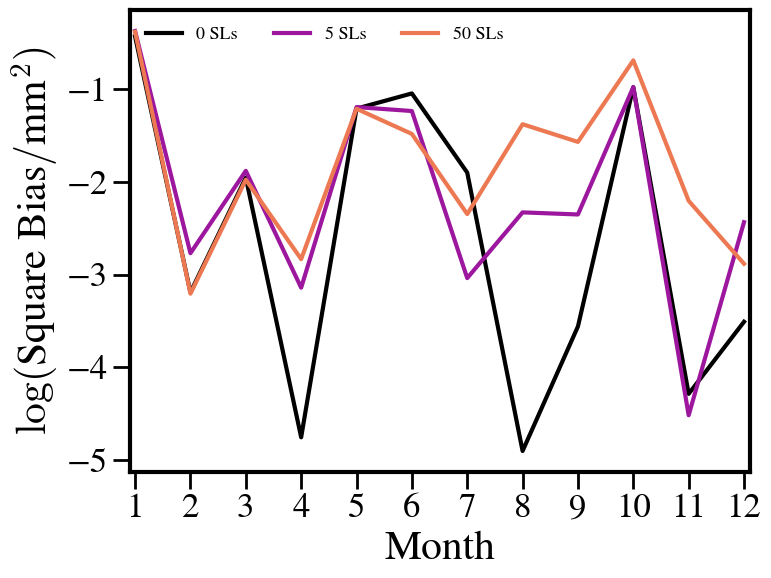

In [88]:
coolors = ['#A5AA52']

plt.plot(np.arange(12), np.log10(hrrr_nosl_bias**2),  color='black', lw=3, label='0 SLs')
plt.plot(np.arange(12), np.log10(hrrr_sl5_bias**2),  color=cm.plasma(1/3), lw=3, label='5 SLs')
plt.plot(np.arange(12),np.log10( hrrr_sl_bias**2),  color=cm.plasma(2/3), lw=3, label='50 SLs')



#plt.plot([-5,15], [0,0], color='black', lw=1, zorder=0)

plt.ylabel("$\log($Square Bias$/$mm$^2)$")
plt.xlabel('Month')

plt.xticks(np.arange(12), labels=[f"{i}" for i in range(1, 13)])
plt.xlim([-0.1,11.1])
#plt.ylim([-0.6, 0.8])
plt.legend(frameon=False, ncol=4, fontsize=13, loc='upper left')
#plt.title("GEFs")

In [63]:
hr = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/data/hrrr/20230110/hrrr.20230110.pcp_24h.t00z.grib2', engine='grib2io')

{230.0: ([<matplotlib.lines.Line2D at 0x154a3c9a5540>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x154a3c9a57b0>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x154a3c9a5a50>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x154a3c9a5cf0>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x154a3c9a5f90>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x154a3c9a6230>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x154a3c9a64d0>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x154a3c9a6770>], [])}

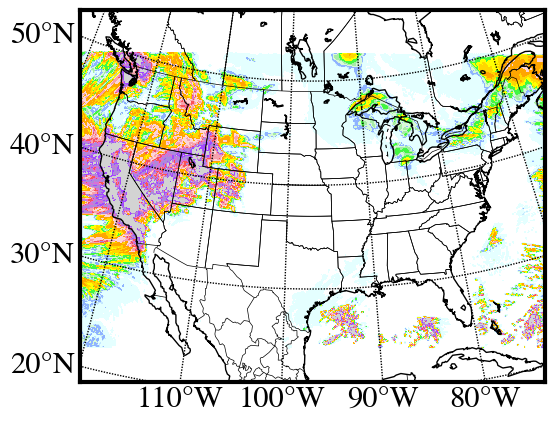

In [65]:
fig, axes = plt.subplots(1,1, figsize=(6,6))

clevs_precip = [0.0,0.25,0.3,0.5,0.75,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12., 15., 20., 25.]

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')

lat_arr = hr.latitude.data
lon_arr = hr.longitude.data
x, y = m(lon_arr, lat_arr)  # transform coordinates
plt.contourf(x, y, hr.APCP.data,levels= clevs_precip,cmap=None,colors=colorst,extend='both')

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

#plt.title(f"GEFS 24h Precip {gday}\nvalid {vday}", fontsize=20)

In [66]:
ur = xr.open_dataset('/scratch2/STI/mdl-sti/Sidney.Lower/data/urma/24h_precip/20230111/urma2p5.20230111.pcp_24h.wexp.grb2', engine='grib2io')

In [ ]:
ur_files = 

{230.0: ([<matplotlib.lines.Line2D at 0x154a3c269390>], []),
 240.0: ([<matplotlib.lines.Line2D at 0x154a3c269600>], []),
 250.0: ([<matplotlib.lines.Line2D at 0x154a3c2698a0>],
  [Text(1084999.9999999998, -49999.999999999985, '110°W')]),
 260.0: ([<matplotlib.lines.Line2D at 0x154a3c269b40>],
  [Text(2174999.9999999995, -49999.999999999985, '100°W')]),
 270.0: ([<matplotlib.lines.Line2D at 0x154a3c269de0>],
  [Text(3264999.9999999995, -49999.999999999985, '90°W')]),
 280.0: ([<matplotlib.lines.Line2D at 0x154a3c26a080>],
  [Text(4364999.999999999, -49999.999999999985, '80°W')]),
 290.0: ([<matplotlib.lines.Line2D at 0x154a3c26a320>], []),
 300.0: ([<matplotlib.lines.Line2D at 0x154a3c26a5c0>], [])}

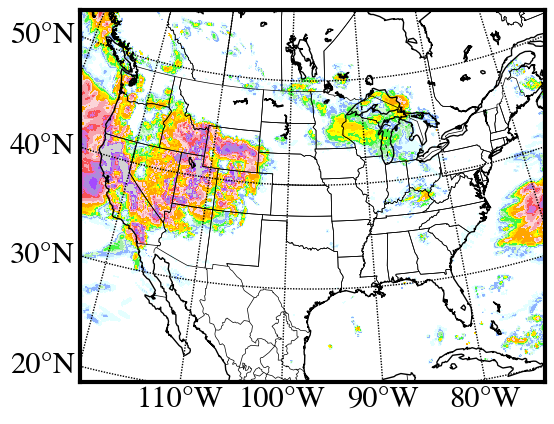

In [67]:
fig, axes = plt.subplots(1,1, figsize=(6,6))

clevs_precip = [0.0,0.25,0.3,0.5,0.75,1.0,1.5,2.0,3.0,5.0,7.0,10.0,12., 15., 20., 25.]

colorst = ['White','#E4FFFF','#C4E8FF','#8FB3FF','#D8F9D8',\
    '#A6ECA6','#42F742','Yellow','Gold','Orange','#FCD5D9','#F6A3AE',\
        '#FA5257','Orchid','#AD8ADB','#A449FF','LightGray'] 

m = Basemap(projection='lcc',lon_0=-97,lat_0=39,width=5e6,height=4e6, resolution='l')

lat_arr = ur.latitude.data
lon_arr = ur.longitude.data
x, y = m(lon_arr, lat_arr)  # transform coordinates
plt.contourf(x, y, ur.APCP.data,levels= clevs_precip,cmap=None,colors=colorst,extend='both')

m.drawcoastlines(ax=axes)
m.drawcountries(ax=axes)
m.drawstates(ax=axes)
m.drawparallels(np.arange(-90.,120.,10.), labels=[1,0,0,0],fontsize=22,ax=axes)
m.drawmeridians(np.arange(0.,360.,10.), labels=[0,0,0,1],fontsize=22,ax=axes)

#plt.title(f"GEFS 24h Precip {gday}\nvalid {vday}", fontsize=20)

In [34]:
import re
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split('(\d+)', s)]

files = sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/gefs/bias_nsls50_*_CONUS.nc"), key=natsort)
gefs_ds = xr.open_mfdataset(files, engine='netcdf4', combine='nested', concat_dim='day')

In [35]:
files = sorted(glob("/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/gefs/bias_nosl_*_CONUS.nc"), key=natsort)
gefs_nosl_ds = xr.open_mfdataset(files, engine='netcdf4', combine='nested', concat_dim='day')

In [36]:
gefs_nosl = gefs_nosl_ds.groupby("day.month")
gefs_sl = gefs_ds.groupby("day.month")

In [43]:
np.shape(np.nanmean(np.nan_to_num(gefs_sl_qmd[:,mem,:] - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))

(31,)

In [44]:
gefs_sl_bias, gefs_nosl_bias, gefs_raw_bias = np.zeros((12, 30)), np.zeros((12, 30)), np.zeros((12, 30))
for i in tqdm(range(1,13)):
    gefs_sl_qmd = gefs_sl[i].gefs_qmd.data.compute()
    urma_analysis = gefs_sl[i].urma_analysis.data.compute()
    gefs_nosl_qmd = gefs_nosl[i].gefs_qmd.data.compute()
    gefs_raw = gefs_sl[i].gefs_raw.data.compute()
    
    for mem in range(30):
        gefs_sl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_sl_qmd[:,mem,:] - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))
        gefs_nosl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_nosl_qmd[:,mem,:] - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))
        gefs_raw_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_raw[:,mem,:] - urma_analysis, nan=np.nan, posinf=np.nan), axis=1))

  0%|          | 0/12 [00:00<?, ?it/s]

In [67]:

files=[]
for n in [2,3,5,10,15,20]:
    files.append(sorted(glob(f"/scratch2/STI/mdl-sti/Sidney.Lower/supplemental_locations/coeffs_from_bias/test_number_sls/gefs/bias_nsls{n}_*_CONUS.nc"), key=natsort))

gefs_ds2 = xr.open_mfdataset(files[0], engine='netcdf4', combine='nested', concat_dim='day')
gefs_ds3 = xr.open_mfdataset(files[1], engine='netcdf4', combine='nested', concat_dim='day')
gefs_ds5 = xr.open_mfdataset(files[2], engine='netcdf4', combine='nested', concat_dim='day')
gefs_ds10 = xr.open_mfdataset(files[3], engine='netcdf4', combine='nested', concat_dim='day')
gefs_ds15 = xr.open_mfdataset(files[4], engine='netcdf4', combine='nested', concat_dim='day')
gefs_ds20 = xr.open_mfdataset(files[5], engine='netcdf4', combine='nested', concat_dim='day')

In [69]:
gefs_2sl = gefs_ds2.groupby("day.month")
gefs_3sl = gefs_ds3.groupby("day.month")
gefs_5sl = gefs_ds5.groupby("day.month")
gefs_10sl = gefs_ds10.groupby("day.month")
gefs_15sl = gefs_ds15.groupby("day.month")
gefs_20sl = gefs_ds20.groupby("day.month")

In [72]:
gefs_2sl_bias,gefs_3sl_bias,gefs_5sl_bias, gefs_10sl_bias, gefs_15sl_bias, gefs_20sl_bias = np.zeros((12, 30)),np.zeros((12, 30)),np.zeros((12, 30)), np.zeros((12, 30)), np.zeros((12, 30)),np.zeros((12, 30))


for i in tqdm(range(1,13)):
    gefs_2sl_qmd = gefs_2sl[i].gefs_qmd.data.compute()
    gefs_3sl_qmd = gefs_3sl[i].gefs_qmd.data.compute()
    gefs_5sl_qmd = gefs_5sl[i].gefs_qmd.data.compute()
    gefs_10sl_qmd = gefs_10sl[i].gefs_qmd.data.compute()
    gefs_15sl_qmd = gefs_15sl[i].gefs_qmd.data.compute()
    gefs_20sl_qmd = gefs_20sl[i].gefs_qmd.data.compute()

    urma_analysis2 = gefs_2sl[i].urma_analysis.data.compute()
    urma_analysis3 = gefs_3sl[i].urma_analysis.data.compute()
    urma_analysis5 = gefs_5sl[i].urma_analysis.data.compute()
    urma_analysis10 = gefs_10sl[i].urma_analysis.data.compute()
    urma_analysis15 = gefs_15sl[i].urma_analysis.data.compute()
    urma_analysis20 = gefs_20sl[i].urma_analysis.data.compute()
    
    for mem in range(30):
        gefs_2sl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_2sl_qmd[:,mem,:] - urma_analysis2, nan=np.nan, posinf=np.nan), axis=1))
        gefs_3sl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_3sl_qmd[:,mem,:] - urma_analysis3, nan=np.nan, posinf=np.nan), axis=1))
        gefs_5sl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_5sl_qmd[:,mem,:] - urma_analysis5, nan=np.nan, posinf=np.nan), axis=1))
        gefs_10sl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_10sl_qmd[:,mem,:] - urma_analysis10, nan=np.nan, posinf=np.nan), axis=1))
        gefs_15sl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_15sl_qmd[:,mem,:] - urma_analysis15, nan=np.nan, posinf=np.nan), axis=1))
        gefs_20sl_bias[i-1,mem] = np.nanmean(np.nanmean(np.nan_to_num(gefs_20sl_qmd[:,mem,:] - urma_analysis20, nan=np.nan, posinf=np.nan), axis=1))

  0%|          | 0/12 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GEFs')

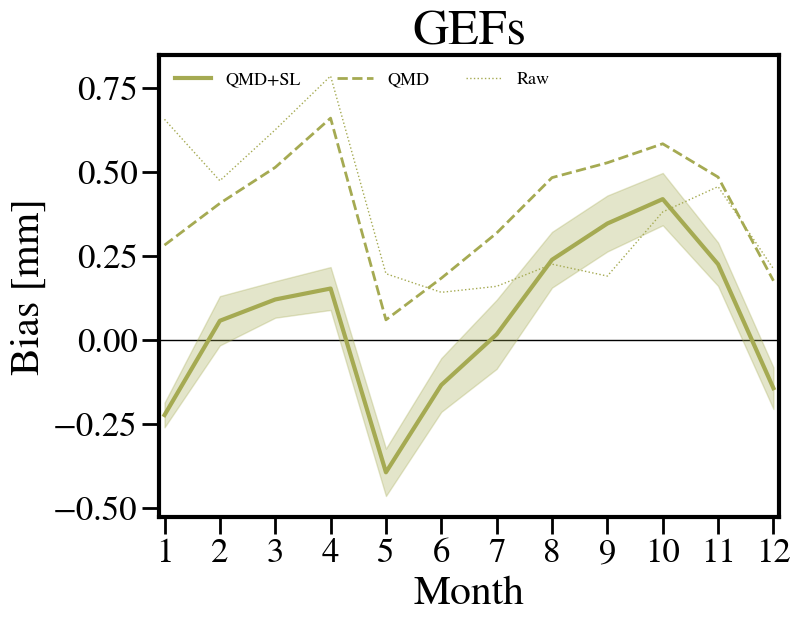

In [46]:
coolors = ['#A5AA52']

#mn = np.nanmean(gefs_sl_bias, axis=1)
#std = np.nanstd(gefs_sl_bias, axis=1)
plt.plot(np.arange(12), np.nanmean(gefs_sl_bias, axis=1), color=coolors[0], lw=3, label='QMD+SL')
plt.fill_between(np.arange(12), mn-std, mn+std,color=coolors[0], alpha=0.3)
plt.plot(np.arange(12), np.nanmean(gefs_nosl_bias, axis=1), color=coolors[0], ls='--', lw=2, label='QMD')
plt.plot(np.arange(12), np.nanmean(gefs_raw_bias, axis=1), color=coolors[0], ls=':', lw=1, label='Raw')

plt.plot([-5,15], [0,0], color='black', lw=1, zorder=0)

plt.ylabel("Bias [mm]")
plt.xlabel('Month')

plt.xticks(np.arange(12), labels=[f"{i}" for i in range(1, 13)])
plt.xlim([-0.1,11.1])
#plt.ylim([-22, 25])
plt.legend(frameon=False, ncol=3, fontsize=13, loc='upper left')
plt.title("GEFs")

In [53]:
cm.viridis(0.5)

(0.127568, 0.566949, 0.550556, 1.0)

Text(0.5, 1.0, 'GEFs')

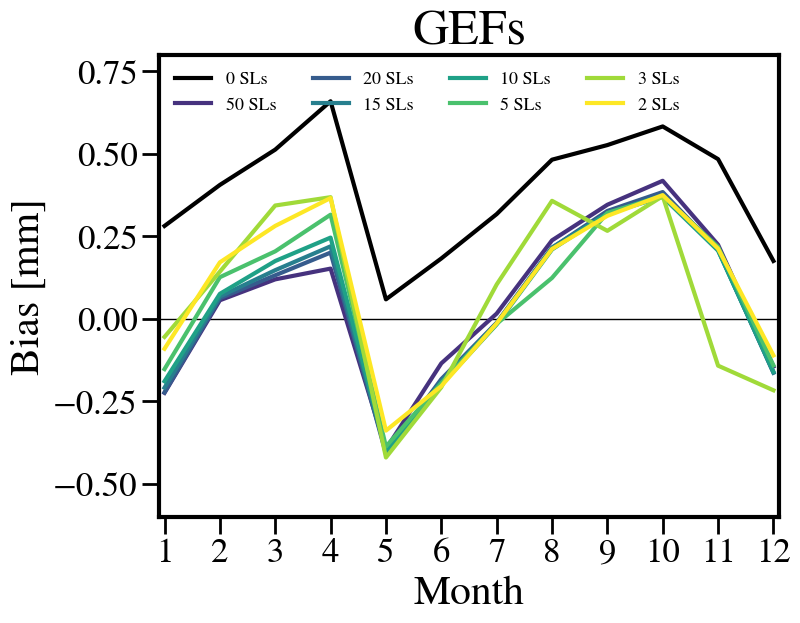

In [74]:
coolors = ['#A5AA52']

plt.plot(np.arange(12), np.nanmean(gefs_nosl_bias, axis=1), color='black', lw=3, label='0 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_sl_bias, axis=1), color=cm.viridis(1/7), lw=3, label='50 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_20sl_bias, axis=1), color=cm.viridis(2/7), lw=3, label='20 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_15sl_bias, axis=1), color=cm.viridis(3/7), lw=3, label='15 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_10sl_bias, axis=1), color=cm.viridis(4/7), lw=3, label='10 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_5sl_bias, axis=1), color=cm.viridis(5/7), lw=3, label='5 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_3sl_bias, axis=1), color=cm.viridis(6/7), lw=3, label='3 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_2sl_bias, axis=1), color=cm.viridis(7/7), lw=3, label='2 SLs')


plt.plot([-5,15], [0,0], color='black', lw=1, zorder=0)

plt.ylabel("Bias [mm]")
plt.xlabel('Month')

plt.xticks(np.arange(12), labels=[f"{i}" for i in range(1, 13)])
plt.xlim([-0.1,11.1])
plt.ylim([-0.6, 0.8])
plt.legend(frameon=False, ncol=4, fontsize=13, loc='upper left')
plt.title("GEFs")

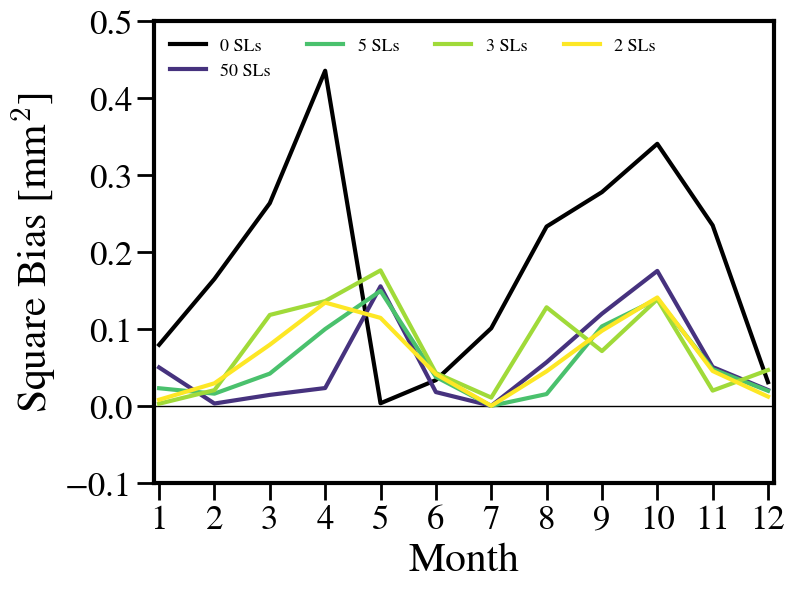

In [75]:
coolors = ['#A5AA52']

plt.plot(np.arange(12), np.nanmean(gefs_nosl_bias, axis=1)**2, color='black', lw=3, label='0 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_sl_bias, axis=1)**2, color=cm.viridis(1/7), lw=3, label='50 SLs')
#plt.plot(np.arange(12), np.nanmean(gefs_20sl_bias, axis=1), color=cm.viridis(2/5), lw=3, label='20 SLs')
#plt.plot(np.arange(12), np.nanmean(gefs_15sl_bias, axis=1), color=cm.viridis(3/5), lw=3, label='15 SLs')
#plt.plot(np.arange(12), np.nanmean(gefs_10sl_bias, axis=1), color=cm.viridis(4/5), lw=3, label='10 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_5sl_bias, axis=1)**2, color=cm.viridis(5/7), lw=3, label='5 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_3sl_bias, axis=1)**2, color=cm.viridis(6/7), lw=3, label='3 SLs')
plt.plot(np.arange(12), np.nanmean(gefs_2sl_bias, axis=1)**2, color=cm.viridis(7/5), lw=3, label='2 SLs')


plt.plot([-5,15], [0,0], color='black', lw=1, zorder=0)

plt.ylabel("Square Bias [mm$^2$]")
plt.xlabel('Month')

plt.xticks(np.arange(12), labels=[f"{i}" for i in range(1, 13)])
plt.xlim([-0.1,11.1])
plt.ylim([-0.1, 0.5])
plt.legend(frameon=False, ncol=4, fontsize=13, loc='upper left')
#plt.title("GEFs")

## terrain dependence

In [173]:
hrrr_sl_bias, hrrr_nosl_bias, hrrr_raw_bias = np.zeros((4, len(hrrr_lat_idx))), np.zeros((4, len(hrrr_lat_idx))), np.zeros((4, len(hrrr_lat_idx)))
for i, mon in tqdm(enumerate([1, 4, 7, 11]), total=4):
    hrrr_sl_qmd = hrrr_sl[mon].hrrr_qmd.data.compute()
    urma_analysis = hrrr_sl[mon].urma_analysis.data.compute()
    hrrr_nosl_qmd = hrrr_nosl[mon].hrrr_qmd.data.compute()
    hrrr_raw = hrrr_sl[mon].hrrr_raw.data.compute()

    hrrr_sl_bias[i,:] = np.nanmean(np.nan_to_num(hrrr_sl_qmd - urma_analysis, nan=np.nan, posinf=np.nan), axis=0)
    hrrr_nosl_bias[i,:] = np.nanmean(np.nan_to_num(hrrr_nosl_qmd - urma_analysis, nan=np.nan, posinf=np.nan), axis=0)
    hrrr_raw_bias[i,:] = np.nanmean(np.nan_to_num(hrrr_raw - urma_analysis, nan=np.nan, posinf=np.nan), axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
@jit
def calculate_local_terrain_std(terrain_height, landmask, minseparation):
    terrain_mean = np.zeros_like(terrain_height)
    terrain_stddev = np.zeros_like(terrain_height)
    ny, nx = np.shape(landmask)
    for j in range(nx):
        for i in range(ny):
            # Compute local domain using minseparation
            ### i = lat
            ### j = lon
            imin=max([0,i-minseparation])
            imax=min([ny,i+minseparation])
            jmin=max([0,j-minseparation])
            jmax=min([nx,j+minseparation])
            
            nsamps=0
            sum_terrain=0.0
            sum_terrain2=0.0
            #Local domain
            for jj in range(jmin,jmax):
                for ii in range(imin,imax):
                    dist=np.sqrt((np.float32(i-ii)**2.0)+(np.float32(j-jj)**2.0))
                    if dist > minseparation:
                        continue
                    elif (landmask[i,j] == 0) and (landmask[ii,jj] == 1):
                        continue
                    else:
                        sum_terrain += terrain_height[ii,jj]
                        sum_terrain2 += terrain_height[ii,jj]**2.0
                        nsamps += 1
            terrain_mean[i,j]=sum_terrain/nsamps
            terrain_stddev[i,j]=np.sqrt((sum_terrain2-(nsamps*terrain_mean[i,j]**2.0))/(nsamps-1))

    return terrain_mean, terrain_stddev

In [19]:
landmask = consts.landmask.data
terrain_height = consts.terrain.data
terrain_mean, terrain_std = calculate_local_terrain_std(terrain_height, landmask, 40.)

In [20]:
sc_terrain_std = terrain_std/np.max(terrain_std)

In [25]:
models = [hrrr_raw_bias, hrrr_nosl_bias, hrrr_sl_bias]
m_names = ['Raw', 'QMD', 'QMD+SL']
months = [1, 4, 7, 11]

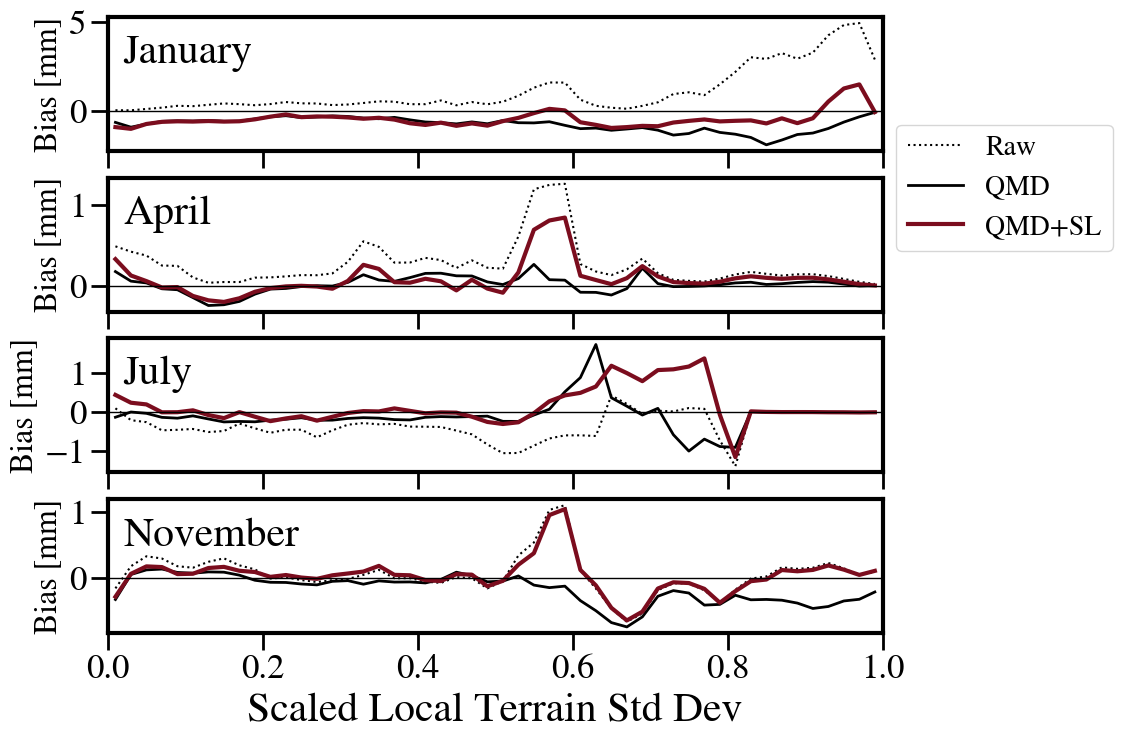

In [31]:
fig, axes = plt.subplots(4, sharex=True, figsize=(10, 8))

axes[0].set_xlim([0,1])
axes[3].set_xlabel('Scaled Local Terrain Std Dev')
#axes[0].set_ylim([-2, 4])

ts = sc_terrain_std[hrrr_lat_idx, hrrr_lon_idx]
coolors = ['#7B0D1E']
for mn in range(4): #months
    for mo in range(3): #models
        mb = models[mo][mn]
        #print(np.shape(mb))
        #print(np.shape(tg))
        bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ts, mb, statistic=np.nanmean, bins=50)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        if mo == 0:
            rr, = axes[mn].plot(bin_centers, bin_means,color='black', ls=':', label=m_names[mo])
        elif mo == 1:
            nsl, = axes[mn].plot(bin_centers, bin_means,color='black',lw=2,  label=m_names[mo])
            #bin_stds, b_, _ = stats.binned_statistic(terrain_height[lat_idx,lon_idx][gps_where_nonzero], model_bias[m], statistic=np.nanstd, bins=np.linspace(0,2000,100))
            #plt.fill_between(bin_centers, bin_means+bin_stds, bin_means-bin_stds,color='black', alpha=0.3)
        else:
            tt, = axes[mn].plot(bin_centers, bin_means, color=coolors[0], lw=3, label=m_names[mo])

    axes[mn].plot([0,10], [0,0], color='black', lw=1.0)
    axes[mn].set_ylabel('Bias [mm]', fontsize=23)
    axes[mn].text(.02,.87, f"{datetime.datetime(2023, months[mn], 4).strftime('%B')}", ha='left', va='top', transform=axes[mn].transAxes)

axes[0].legend(handles=[rr, nsl, tt], labels=m_names,bbox_to_anchor=(1., 0.3))

    
#plt.ylabel('Bias [mm]')
#plt.xlabel('Terrain Height [m]')
#plt.legend(frameon=False, ncol=3, fontsize=16, loc='upper left')
#plt.xlim([-1,2000])
#plt.ylim([-1, 1])
#plt.text(.98,.13, f"{datetime.datetime(2023, months[month], 4).strftime('%B')}", ha='right', va='bottom', transform=ax.transAxes)
#plt.text(.98, .87, f"URMA APCP > 0.254mm",fontsize=15, ha='right', va='top', transform=ax.transAxes)

In [175]:
gefs_sl_bias, gefs_nosl_bias, gefs_raw_bias = np.zeros((4, 30, len(gefs_lat_idx))), np.zeros((4, 30, len(gefs_lat_idx))), np.zeros((4, 30, len(gefs_lat_idx)))
for i, mon in tqdm(enumerate([1,4,7,11]), total=4):
    gefs_sl_qmd = gefs_sl[mon].gefs_qmd.data.compute()
    urma_analysisG = gefs_sl[mon].urma_analysis.data.compute()
    gefs_nosl_qmd = gefs_nosl[mon].gefs_qmd.data.compute()
    gefs_raw = gefs_sl[mon].gefs_raw.data.compute()
    
    for mem in range(30):
        gefs_sl_bias[i,mem, :] = np.nanmean(np.nan_to_num(gefs_sl_qmd[:,mem,:] - urma_analysisG, nan=np.nan, posinf=np.nan), axis=0)
        gefs_nosl_bias[i,mem,:] = np.nanmean(np.nan_to_num(gefs_nosl_qmd[:,mem,:] - urma_analysisG, nan=np.nan, posinf=np.nan), axis=0)
        gefs_raw_bias[i,mem,:] = np.nanmean(np.nan_to_num(gefs_raw[:,mem,:] - urma_analysisG, nan=np.nan, posinf=np.nan), axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [46]:
models_g = [gefs_raw_bias, gefs_nosl_bias,gefs_sl_bias]
models_h = [hrrr_raw_bias, hrrr_nosl_bias,hrrr_sl_bias]
m_names = ['Raw', 'QMD', 'QMD+SL']
months = [1, 4, 7, 11]

In [151]:
hrrr_points = np.reshape((hrrr_lat_idx,hrrr_lon_idx), (2, -1), order='C').T
gefs_points = np.reshape((gefs_lat_idx,gefs_lon_idx), (2, -1), order='C').T

In [162]:
hrrr_fc = hrrr_sl_qmd
gefs_fc = gefs_sl_qmd

In [193]:
ny, nx = np.shape(lat_arr)

In [203]:

def get_gefs_hrrr_average(ny, nx, hrrr_points, gefs_points, 
                          hrrr_sl, hrrr_nosl, hrrr_raw,hrrr_analysis, 
                          gefs_sl, gefs_nosl, gefs_raw, gefs_analysis):
    average_sl = np.zeros((ny, nx))
    average_nosl = np.zeros((ny, nx))
    average_raw = np.zeros((ny, nx))
    hrrr_tree = scipy.spatial.cKDTree(hrrr_points)
    gefs_tree = scipy.spatial.cKDTree(gefs_points)
    
    for lat in tqdm(range(ny)):
        for lon in range(nx):
            count = 0
            sum_sl, sum_nosl, sum_raw = 0,0,0
            pp = scipy.spatial.cKDTree([[lat, lon]])
            h_q = pp.query_ball_tree(hrrr_tree, r=1e-9)
            g_q = pp.query_ball_tree(gefs_tree, r=1e-9)
            
            if (len(h_q[0]) > 0):
                #print("valid HRRR point")
                hrrr_idx = h_q[0][0]
                sum_sl += np.nanmean((hrrr_sl[:,hrrr_idx] - hrrr_analysis[:,hrrr_idx]), axis=0)
                sum_nosl += np.nanmean((hrrr_nosl[:,hrrr_idx] - hrrr_analysis[:,hrrr_idx]), axis=0)
                sum_raw += np.nanmean((hrrr_raw[:,hrrr_idx] - hrrr_analysis[:,hrrr_idx]), axis=0)
                count += 1
            
            if (len(g_q[0]) > 0):
                #print("valid GEFs point")
                gefs_idx = g_q[0][0]
                for mem in range(30):
                    sum_sl += np.nanmean((gefs_sl[:,mem, gefs_idx] - gefs_analysis[:,gefs_idx]), axis=0)
                    sum_nosl += np.nanmean((gefs_nosl[:,mem, gefs_idx] - gefs_analysis[:,gefs_idx]), axis=0)
                    sum_raw += np.nanmean((gefs_raw[:,mem, gefs_idx] - gefs_analysis[:,gefs_idx]), axis=0)
                    count += 1
        
            if count > 0:
                average_sl[lat, lon] = sum_sl / count
                average_nosl[lat, lon] = sum_nosl / count
                average_raw[lat, lon] = sum_raw / count
            else:
                average_sl[lat, lon] = np.nan
                average_nosl[lat, lon] = np.nan
                average_raw[lat, lon] = np.nan
    return average_sl, average_nosl, average_raw

In [209]:
gefs_hrrr_sl_average = np.zeros((4, ny, nx))
gefs_hrrr_nosl_average = np.zeros((4, ny, nx))
gefs_hrrr_raw_average = np.zeros((4, ny, nx))

for i, mon in tqdm(enumerate([1,4,7,11]), total=4):
    gefs_sl_qmd = gefs_sl[mon].gefs_qmd.data.compute()
    urma_analysisG = gefs_sl[mon].urma_analysis.data.compute()
    gefs_nosl_qmd = gefs_nosl[mon].gefs_qmd.data.compute()
    gefs_raw = gefs_sl[mon].gefs_raw.data.compute()

    
    hrrr_sl_qmd = hrrr_sl[mon].hrrr_qmd.data.compute()
    urma_analysis = hrrr_sl[mon].urma_analysis.data.compute()
    hrrr_nosl_qmd = hrrr_nosl[mon].hrrr_qmd.data.compute()
    hrrr_raw = hrrr_sl[mon].hrrr_raw.data.compute()
    print("starting averages")
    avs = get_gefs_hrrr_average(ny, nx, hrrr_points, gefs_points,hrrr_sl_qmd, hrrr_nosl_qmd, hrrr_raw, urma_analysis,gefs_sl_qmd, gefs_nosl_qmd, gefs_raw, urma_analysisG)

    gefs_hrrr_sl_average[i] = avs[0]
    gefs_hrrr_nosl_average[i] = avs[1]
    gefs_hrrr_raw_average[i] = avs[2]
    

  0%|          | 0/4 [00:00<?, ?it/s]

starting averages


  0%|          | 0/1597 [00:00<?, ?it/s]

starting averages


  0%|          | 0/1597 [00:00<?, ?it/s]

starting averages


  0%|          | 0/1597 [00:00<?, ?it/s]

starting averages


  0%|          | 0/1597 [00:00<?, ?it/s]

In [210]:
np.shape(gefs_hrrr_sl_average)

(4, 1597, 2345)

In [211]:
models = [gefs_hrrr_raw_average, gefs_hrrr_nosl_average, gefs_hrrr_sl_average]
#models_h = [hrrr_raw_bias, hrrr_nosl_bias,hrrr_sl_bias]
m_names = ['Raw', 'QMD', 'QMD+SL']
months = [1, 4, 7, 11]

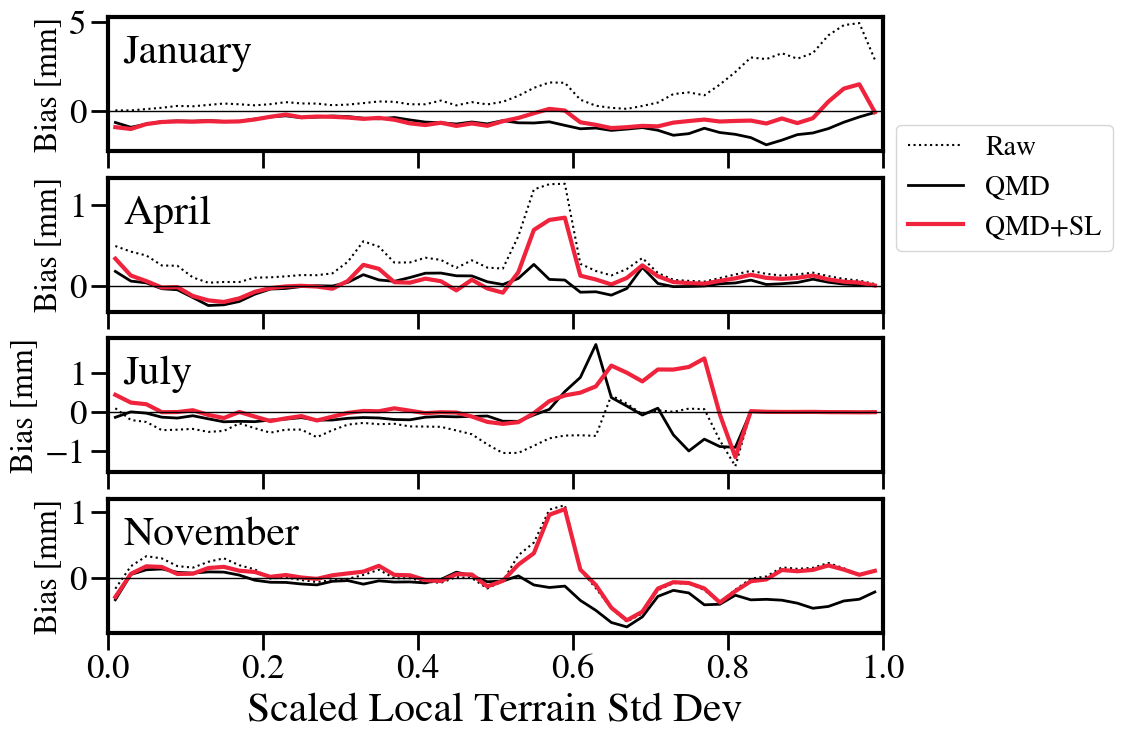

In [213]:
fig, axes = plt.subplots(4, sharex=True, figsize=(10, 8))

axes[0].set_xlim([0,1])
axes[3].set_xlabel('Scaled Local Terrain Std Dev')
#axes[0].set_ylim([-2, 4])

th = sc_terrain_std[hrrr_lat_idx, hrrr_lon_idx]
tg = sc_terrain_std[gefs_lat_idx, gefs_lon_idx]
coolors = ['#EF233C']

all_terrain = np.ravel(sc_terrain_std)

for mn in range(4): #months
    for mo in range(3): #models
        avem = np.ravel(models[mo][mn])

        both_models = np.append(gm, hm)
        bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(all_terrain, avem, statistic=np.nanmean, bins=50)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        if mo == 0:
            rr, = axes[mn].plot(bin_centers, bin_means,color='black', ls=':', label=m_names[mo])
        elif mo == 1:
            nsl, = axes[mn].plot(bin_centers, bin_means,color='black',lw=2,  label=m_names[mo])
            #bin_stds, b_, _ = stats.binned_statistic(terrain_height[lat_idx,lon_idx][gps_where_nonzero], model_bias[m], statistic=np.nanstd, bins=np.linspace(0,2000,100))
            #plt.fill_between(bin_centers, bin_means+bin_stds, bin_means-bin_stds,color='black', alpha=0.3)
        else:
            tt, = axes[mn].plot(bin_centers, bin_means, color=coolors[0], lw=3, label=m_names[mo])

    axes[mn].plot([0,10], [0,0], color='black', lw=1.0)
    axes[mn].set_ylabel('Bias [mm]', fontsize=23)
    axes[mn].text(.02,.87, f"{datetime.datetime(2023, months[mn], 4).strftime('%B')}", ha='left', va='top', transform=axes[mn].transAxes)

axes[0].legend(handles=[rr, nsl, tt], labels=m_names,bbox_to_anchor=(1., 0.3))

    
#plt.ylabel('Bias [mm]')
#plt.xlabel('Terrain Height [m]')
#plt.legend(frameon=False, ncol=3, fontsize=16, loc='upper left')
#plt.xlim([-1,2000])
#plt.ylim([-1, 1])
#plt.text(.98,.13, f"{datetime.datetime(2023, months[month], 4).strftime('%B')}", ha='right', va='bottom', transform=ax.transAxes)
#plt.text(.98, .87, f"URMA APCP > 0.254mm",fontsize=15, ha='right', va='top', transform=ax.transAxes)